# **mGrana Challenge**

**Developer**: COLLANTE, Gerardo

**Fecha**: 26/7/2021

El dataset consiste en `train` y `test` sets de reviews de películas. Para el `train` set tenés labels binarios (si el review es bueno o malo) y para el test set, solo los reviews.

La consigna del challenge es la siguiente:

* [1 .Hacer un breve análisis exploratorio de los datos.](#chapter1)
* [2 .Entrenar un modelo de ML con los datos de train, que busque predecir si el review es bueno o malo en base al texto del review..](#chapter2)
* [3 .Una medida estimada de que accuracy aproximado esperamos en el `test` set.](#chapter3)
* [4 .Crear predicciones para el dataset test.](#chapter4)

El entregable por ende es:
- Un *Jupyter Notebook* donde esté contenido el análisis, pre-procesamiento del dataset, entrenamiento del modelo, evaluación, etc.
- Un archivo `test.csv` que esté en el mismo formato que `challenge_train_.csv`, y que contenga no solo los reviews del test set, sino las predicciones que el modelo hace para estos reviews.

La idea es que utilices librerías clásicas de *Python* como *Pandas*, *Numpy* y *SkLearn* (o inclusive *PyTorch* o *TensorFlow*), pero sos libre de utilizar cualquier librería de *Python* que te convenga. 

In [1]:
!pip install torchtext
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 782.7 MB 3.7 kB/s  eta 0:00:01     |███████                         | 173.2 MB 48.0 MB/s eta 0:00:13     |███████▎                        | 176.7 MB 48.0 MB/s eta 0:00:13     |███████▎                        | 178.5 MB 48.0 MB/s eta 0:00:13     |███████▌                        | 182.2 MB 48.0 MB/s eta 0:00:13     |███████▌                        | 184.0 MB 48.0 MB/s eta 0:00:13     |███████▋                        | 185.9 MB 48.0 MB/s eta 0:00:13     |███████████████████████████████▏| 761.6 MB 63.6 MB/s eta 0:00:01��███████████▏| 763.3 MB 63.6 MB/s eta 0:00:01     |███████████████████████████████▎| 765.6 MB 63.6 MB/s eta 0:00:01     |███████████████████████████████▍| 766.9 MB 63.6 MB/s eta 0:00:01     |███████████████████████████████▌| 771.7 MB 63.6 MB/s eta 0:00:01     |███████████████████████████████▋| 774.5 MB 63.6 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [2]:
!nvidia-smi

Mon Jul 26 19:04:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as pl
import re
import seaborn as sns
import spacy
import string
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython import display
from sklearn.model_selection import train_test_split
from os.path import join
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torchtext.data import Field, TabularDataset, BucketIterator

In [4]:
SEED = 42

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
TRAIN = True # For train model
LOAD = False # For load weights in model
MODEL_PATH = 'movies-sa.pt'
SMALL = False # Use small dataset for fast coding

## Load files

In [6]:
DATAPATH = '../input/mgrana-dataset'
TEST_PATH = join(DATAPATH, 'challenge_test_.csv')
TRAIN_PATH = join(DATAPATH, 'challenge_train_.csv')

In [7]:
target = pd.read_csv(TEST_PATH, index_col=0)
original = pd.read_csv(TRAIN_PATH, index_col=0)

In [8]:
if SMALL:
    original = original.sample(frac=0.05)

In [9]:
original

,text,sentiment
0,Horrible film. About an old crusty painter who...,1
1,This is the worst movie I've ever seen in my l...,1
2,"I was really, really disappointed with this mo...",1
3,Wow I loved this movie! It is about normal lif...,0
4,Gung Ho is one of those movies that you will w...,0
...,...,...
22495,"If another Hitler ever arises, it will be than...",1
22496,"While I am not a big fan of musicals, I have l...",0
22497,"No laughs whatsoever. Yes, I watched this enti...",1
22498,Undoubtedly one of the great John Ford's maste...,0


# 1. Brief exploratory data analysis <a class="anchor" id="chapter1"></a>

In [10]:
original['length'] = original.text.apply(lambda x: len(x.split()))

In [11]:
def remove_punctuation(s:str)->str:
    """
    Parameters
    ----------
    s: string

    Returns
    -------
    str
    """
    return re.sub("[^\w\s]", "", s)

In [12]:
analysis = original.text.apply(lambda x: remove_punctuation(x.lower()))

In [13]:
import plotly.express as px
df = px.data.tips()
fig = px.histogram(original, 
                   x="length", 
                   nbins=50, 
                   color="sentiment", 
                   color_discrete_sequence=['red','green'], 
                   title='Mean length of review by sentiment')
fig.show()

In [14]:
original['raw'] = original.text.apply(lambda x: remove_punctuation(x.lower()))

In [15]:
original

,text,sentiment,length,raw
0,Horrible film. About an old crusty painter who...,1,188,horrible film about an old crusty painter who ...
1,This is the worst movie I've ever seen in my l...,1,152,this is the worst movie ive ever seen in my li...
2,"I was really, really disappointed with this mo...",1,308,i was really really disappointed with this mov...
3,Wow I loved this movie! It is about normal lif...,0,117,wow i loved this movie it is about normal life...
4,Gung Ho is one of those movies that you will w...,0,130,gung ho is one of those movies that you will w...
...,...,...,...,...
22495,"If another Hitler ever arises, it will be than...",1,274,if another hitler ever arises it will be thank...
22496,"While I am not a big fan of musicals, I have l...",0,241,while i am not a big fan of musicals i have lo...
22497,"No laughs whatsoever. Yes, I watched this enti...",1,210,no laughs whatsoever yes i watched this entire...
22498,Undoubtedly one of the great John Ford's maste...,0,587,undoubtedly one of the great john fords master...


In [16]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

def get_words(df, top_N, sentiment):
    words = df[df.sentiment==sentiment].raw.str.cat(sep=' ').split()
    
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w.lower() in stop_words]
    
    label = 'negative' if sentiment else 'positive'
    return pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', f'freq_{label}']).set_index('Word')

In [17]:
NTOP = 50

words_df = pd.concat([get_words(original, NTOP, 0), get_words(original, NTOP, 1)], axis=1).fillna(0).astype(int)

In [18]:
def plot_most_used_words(df, sentiment, top):
    color = 'tab:red' if sentiment=='negative' else 'tab:green'
    df[f'freq_{sentiment}'].sort_values().plot(kind='bar',
                                  title=f'Top-{top} common words used in {sentiment} reviews',
                                  figsize=(16,8),
                                  legend=False,
                                  grid=True,
                                  color= color
                               )

In [19]:
def my_func(x, y):
    return np.linalg.norm(x-y)

In [20]:
words_df['distance'] = words_df.apply(lambda x: my_func(x['freq_negative'], x['freq_positive']), axis=1).sort_values()

In [21]:
TOP = 10
freq_positive = words_df.sort_values(['freq_negative', 'distance'], ascending=[True, False]).head(TOP)
freq_negative = words_df.sort_values(['freq_positive', 'distance'], ascending=[True, False]).head(TOP)

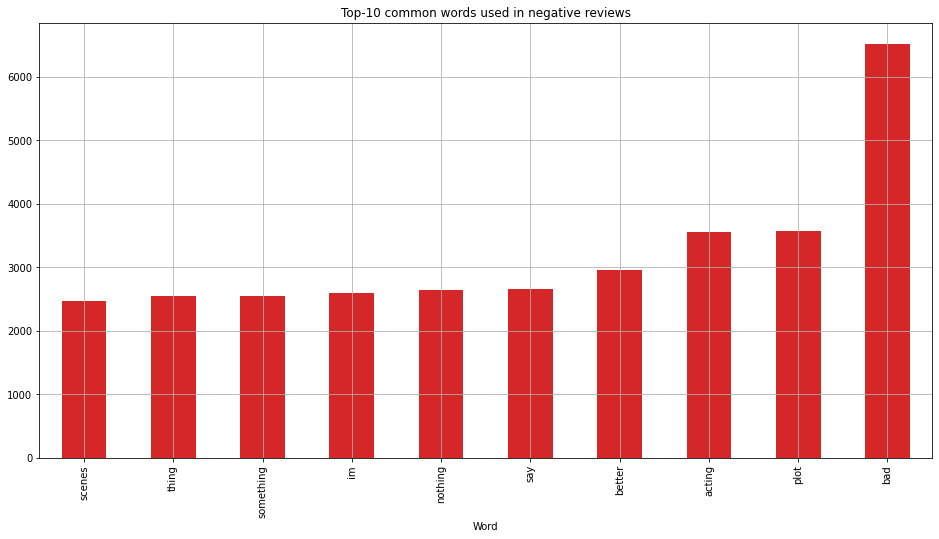

In [22]:
plot_most_used_words(freq_negative, 'negative', TOP)

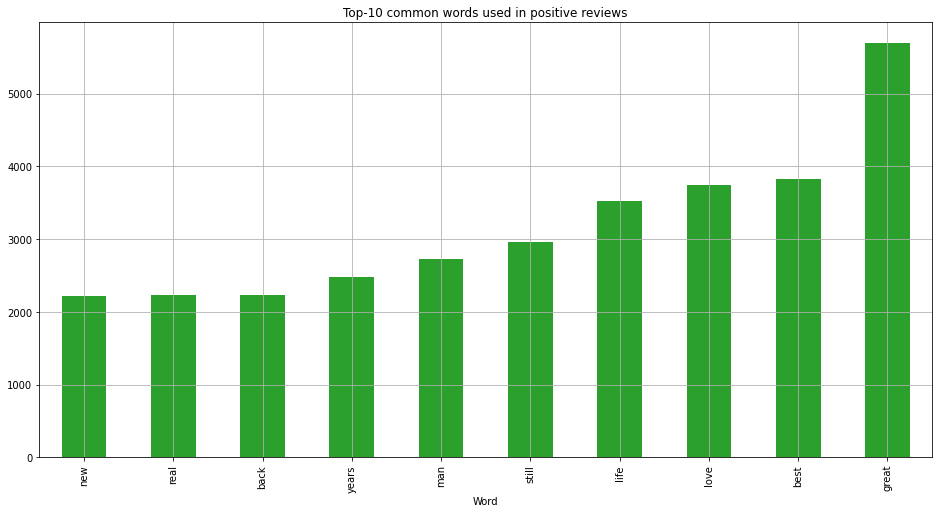

In [23]:
plot_most_used_words(freq_positive, 'positive', TOP)

# 2. Train an ML model with the train data, which seeks to predict whether the review is good or bad based on the text of the review. <a class="anchor" id="chapter2"></a>

## Creation of dataset

In [24]:
def split_train_test(df: pd.DataFrame, test_size: float, random_state: int)->pd.DataFrame:
    """analysis df in train/test
    Parameters
    ----------
    df
    test_size
    random_state

    Returns
    -------
    splitted df
    """
    return train_test_split(
        df, test_size=test_size, random_state=random_state, stratify=df["sentiment"]
    )

In [25]:
# 70% train, 20% test and 10% validation
test_size = 0.3 # 70% train
validation_size = 2/3 # 20% test

train, test = split_train_test(original, test_size, SEED)
validation, test = split_train_test(test, validation_size, SEED)

In [26]:
# Save DataFrames
train.to_csv('train.csv')
test.to_csv('test.csv')
validation.to_csv('validation.csv')

In [27]:
print(f'Train percentage of dataset: {len(train)/len(original)*100:.0f}%')
print(f'Test percentage of dataset: {len(test)/len(original)*100:.0f}%')
print(f'Validation percentage of dataset: {len(validation)/len(original)*100:.0f}%')

Train percentage of dataset: 70%
Test percentage of dataset: 20%
Validation percentage of dataset: 10%


<AxesSubplot:title={'center':'Numbers of reviews per type'}>

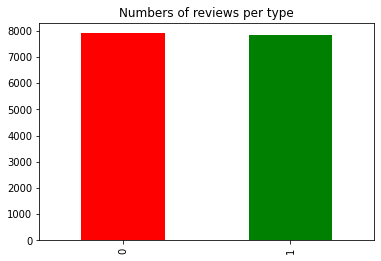

In [28]:
train.sentiment.value_counts().plot(kind='bar', color=['r','g'], title='Numbers of reviews per type')

## Load datasets

In [29]:
TEXT = Field(sequential=True,
             tokenize = 'spacy',
             tokenizer_language = 'en_core_web_lg',
             use_vocab=True,
             lower=True,
             include_lengths = True)

LABEL = Field(sequential=False, use_vocab=False)

fields = {'text': ('text', TEXT), 'sentiment':('label', LABEL)}

/opt/conda/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning:

Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.



In [30]:
train_data, test_data, validation_data = TabularDataset.splits(
    path='.',
    train='train.csv',
    test='test.csv',
    validation='validation.csv',
    format='csv',
    fields=fields)

/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:68: UserWarning:

Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.

/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:52: UserWarning:

Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.



## Compute vocabulary optimal size

In [31]:
def get_all_words(df:pd.DataFrame, column:str)->list:
    """
    Get all words from DataFrame
    Parameters
    ----------
    df
    column

    Returns
    -------
    list:
        words
    """
    all_words = []
    for sentence in df[column]:
        for word in sentence.split():
            all_words.append(word.lower())
    return all_words

In [32]:
words = get_all_words(original, 'text')
words = [remove_punctuation(word) for word in words]
words = list(set(words))
words.sort()

In [33]:
VOCAB_SIZE= len(words)
print(f'The dataset have {VOCAB_SIZE} words.')

The dataset have 105565 words.


In [34]:
def get_all_glove_words(filepath:str)->list:
    """
    Parameters
    ----------
    filepath: str

    Returns
    -------
    list:
        All words in glove
    """
    with open(filepath) as f:
        text = f.readlines()
        word_list = [line.strip().split()[0] for line in text]
    return word_list

In [35]:
glove_path = '../input/glove6b300dtxt/glove.6B.300d.txt'
glove_words = get_all_glove_words(glove_path)
print(f'The Glove dataset have {len(glove_words)} words.')

The Glove dataset have 400000 words.


In [36]:
%%time
# Match only words that appears in both original dataset and Glove
# The purpose is find the optimal size of vocab length
my_list = [word if word in glove_words else '' for word in words]
VOCAB_SIZE = len(set(my_list))
#VOCAB_SIZE = 59_885
print(f'The optimal amount of words in vocabulary is {VOCAB_SIZE} words')

The optimal amount of words in vocabulary is 59885 words
CPU times: user 5min 20s, sys: 138 ms, total: 5min 20s
Wall time: 5min 21s


In [37]:
MAX_VOCAB_SIZE = VOCAB_SIZE
EMBEDDING_DIM = 300 #200, 300 other possibilities
#"glove.6B.100d"
vectors = f"glove.6B.{EMBEDDING_DIM}d"

TEXT.build_vocab(train_data, 
                 max_size=MAX_VOCAB_SIZE,
                 vectors = vectors,
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:48, 5.12MB/s]                               
100%|█████████▉| 399999/400000 [00:51<00:00, 7818.65it/s]


## Create iterators for train/validation

In [38]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, test_iterator, validation_iterator = BucketIterator.splits((train_data, 
                                                                            test_data, 
                                                                            validation_data),            
                                                                           batch_size=BATCH_SIZE,
                                                                           sort_within_batch = True,
                                                                           sort_key = lambda x: len(x.text),
                                                                           device=device)

/opt/conda/lib/python3.7/site-packages/torchtext/data/iterator.py:48: UserWarning:

BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.



## Define model

In [39]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-1,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

## Create model

In [57]:
INPUT_DIM = len(TEXT.vocab)
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [58]:
print(model)

RNN(
  (embedding): Embedding(59887, 300, padding_idx=1)
  (rnn): LSTM(300, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [59]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.3310,  0.8878,  2.3739,  ...,  1.0084, -0.5916, -0.4795],
        ...,
        [ 0.0932, -0.2115, -1.6305,  ..., -0.1988, -0.8818, -0.2156],
        [-0.2610, -0.5519,  0.6575,  ..., -0.9465, -0.8492,  0.6217],
        [-0.1561, -0.0687,  0.6755,  ...,  0.7659,  0.4879,  1.5597]])


In [60]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr = 0.01

optimizer = optim.Adam(model.parameters())#, lr=lr)
criterion = nn.BCEWithLogitsLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min')

model = model.to(device)
criterion = criterion.to(device)

## Set metric

In [61]:
def binary_accuracy(y_pred:torch.Tensor, y_real:torch.Tensor)->torch.Tensor:
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    Parameters
    ----------
    y_pred: predictions
    y_real: real

    Returns
    -------
    Accuracy
    """
    y_pred = torch.round(torch.sigmoid(y_pred))
    return (y_pred == y_real).float().mean()

# Train & eval

In [62]:
def train(model, iterator, optimizer, criterion):
    """
    Function to train model
    Parameters
    ----------
    model
    iterator
    optimizer
    criterion

    Returns
    -------
    Tuple:
        [Loss, Acc]
    """
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        # Reset gradients values to zero, useful in RNNs
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        label = batch.label.float()
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, label)
        acc = binary_accuracy(predictions, label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [63]:
def evaluate(model, iterator, criterion):
    """
    Function to eval model
    Parameters
    ----------
    model
    iterator
    criterion

    Returns
    -------
    Tuple:
        [Loss, Acc]
    """
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            label = batch.label.float()
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, label)
            
            acc = binary_accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [64]:
def plot_training(train_losses:list, test_losses:list, epochs:int):
    """
    Function to plot train/test losses
    Parameters
    ----------
    train_losses
    test_losses
    epochs

    Returns
    -------

    """
    pl.figure(figsize=(10,5))
    pl.title("Training and Test Loss")
    pl.xlim(0, epochs)
    pl.xticks(range(0, epochs+1, 1))
    pl.grid()
    pl.plot(train_losses,label="train")
    pl.plot(test_losses,label="test")
    pl.xlabel("Epochs")
    pl.ylabel("Loss")
    pl.legend()
    display.clear_output(wait=True)
    display.display(pl.gcf())

In [65]:
def epoch_time(start_time: float, end_time:float)->int:
    """
    Compute epoch time
    Parameters
    ----------
    start_time
    end_time

    Returns
    -------
    amount of time for epoch
    """
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [66]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

## Train model

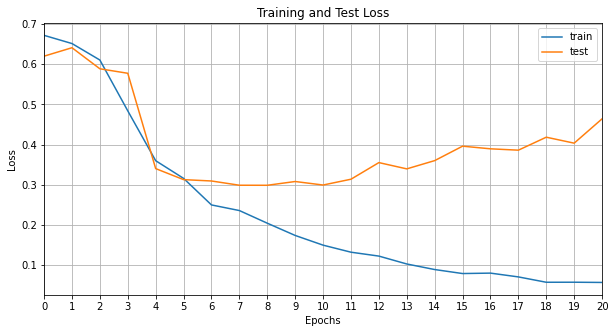

100%|██████████| 21/21 [13:29<00:00, 38.56s/it]

Epoch: 21 | Epoch Time: 0m 37s | lr: 0.001
	Train Loss: 0.056 | Train Acc: 97.91%
	Test Loss: 0.464  | Test Acc: 89.31%
Best Test Loss: 0.298 | Best Test Acc: 89.97%


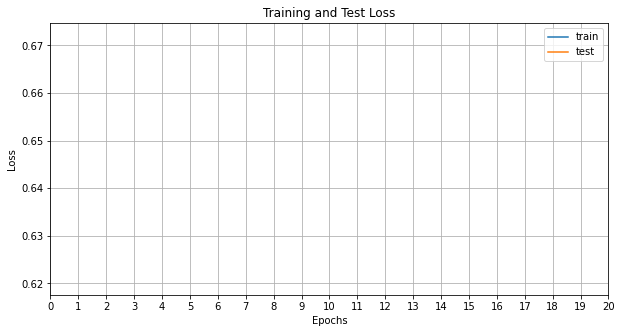

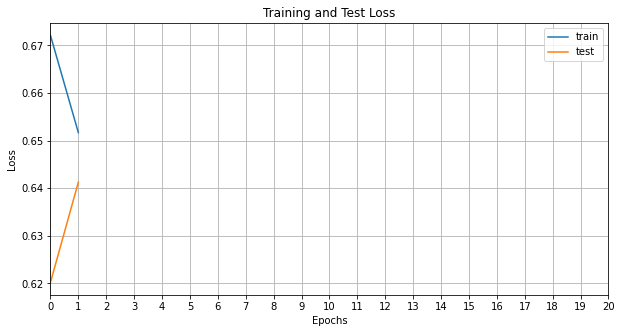

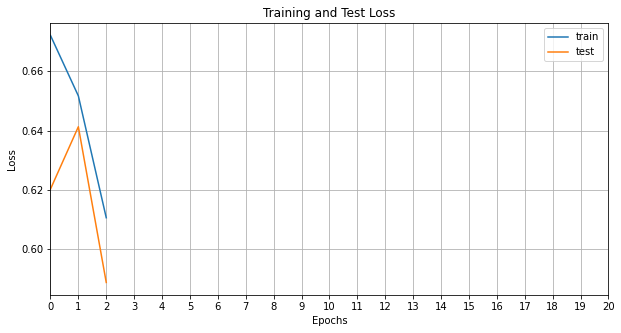

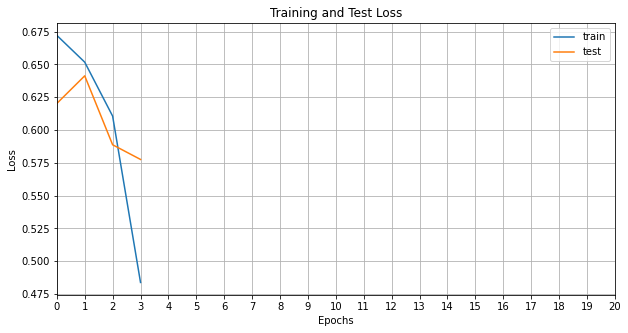

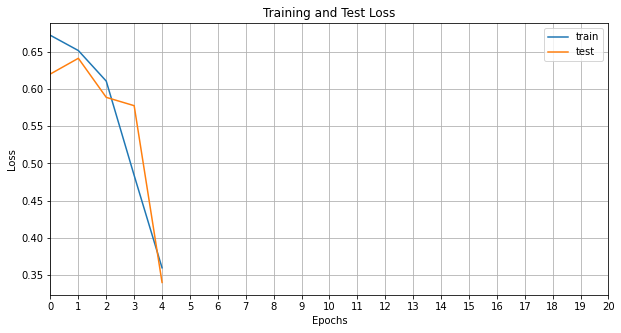

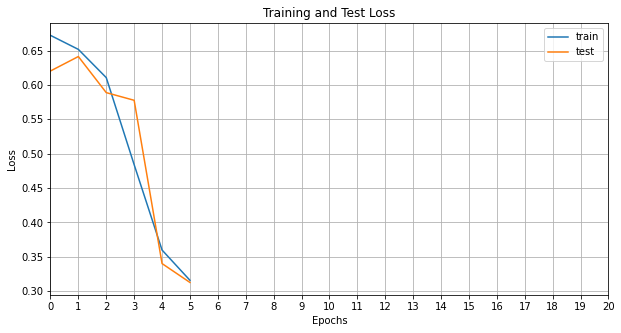

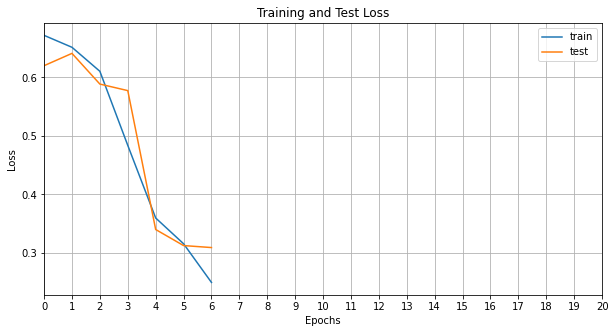

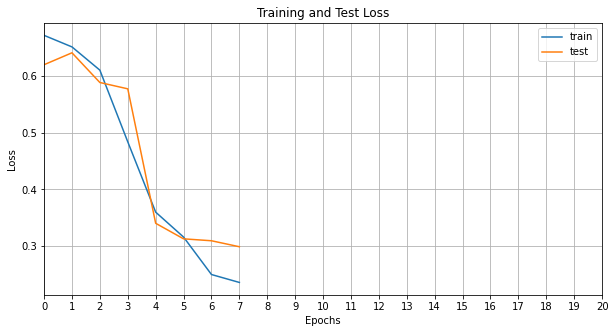

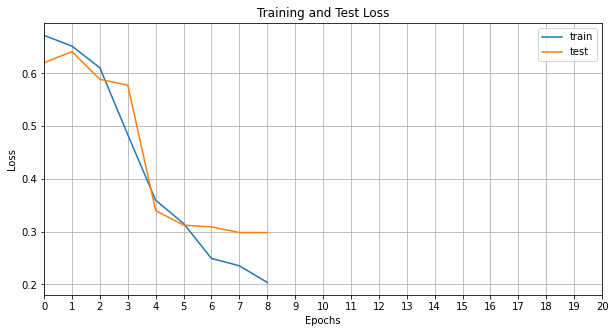

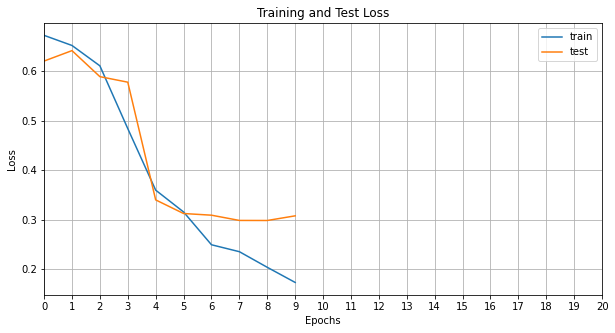

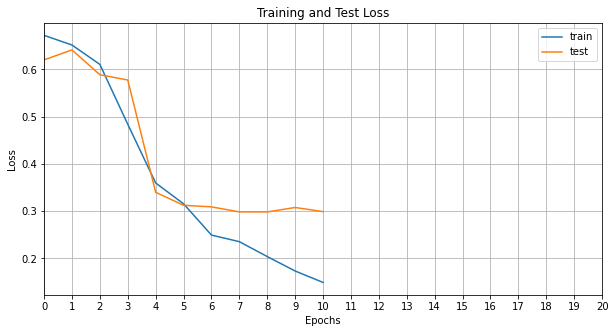

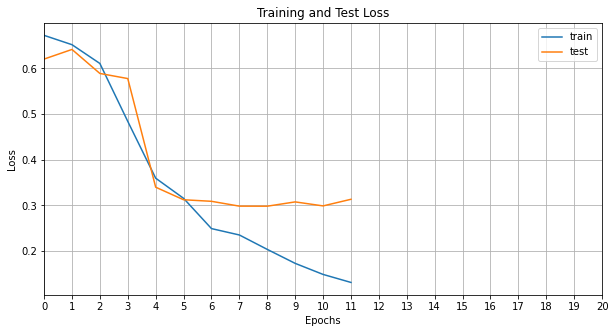

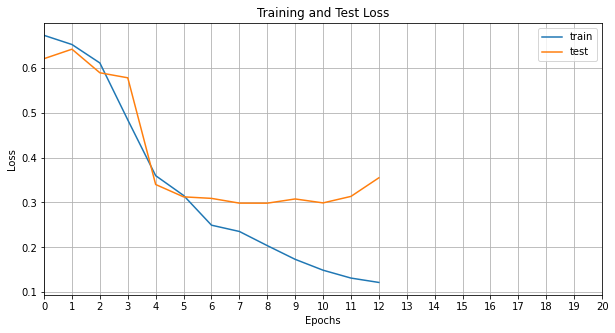

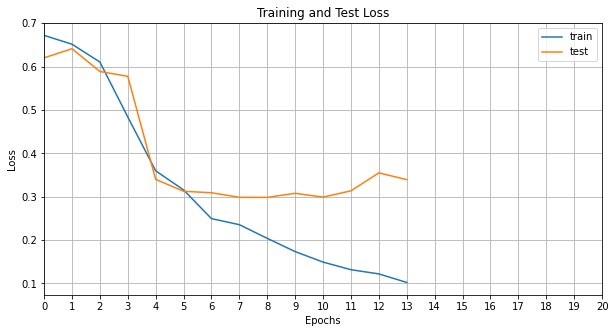

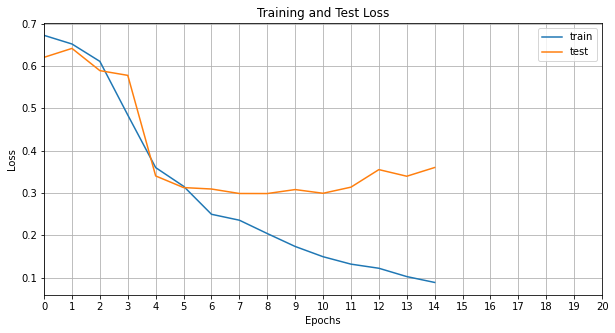

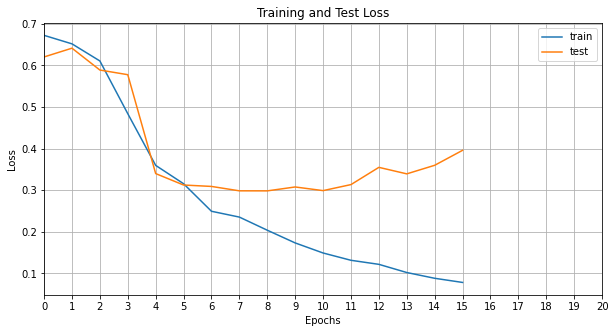

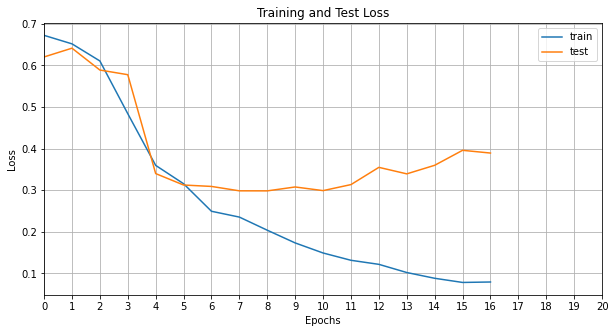

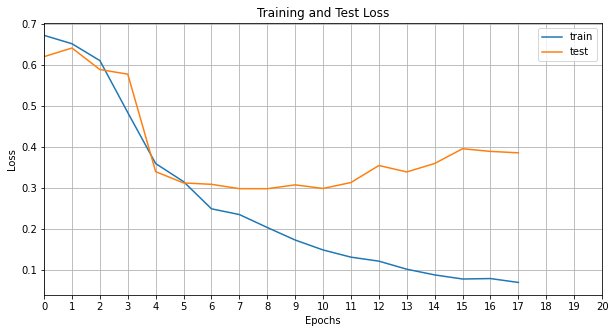

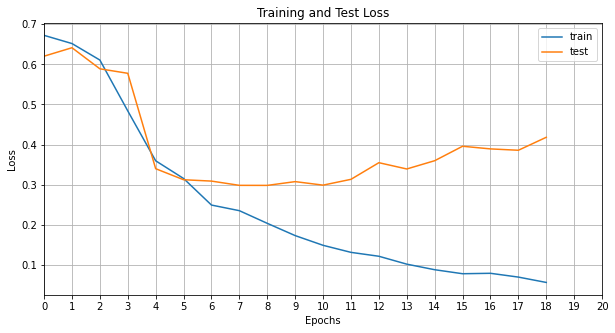

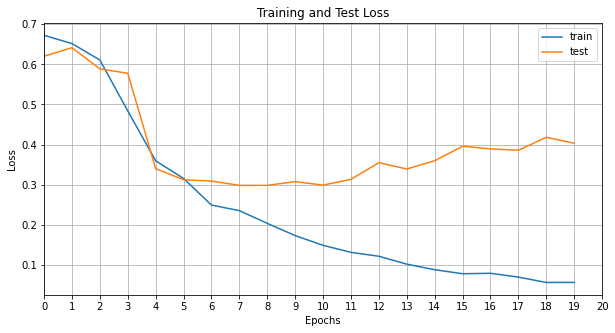

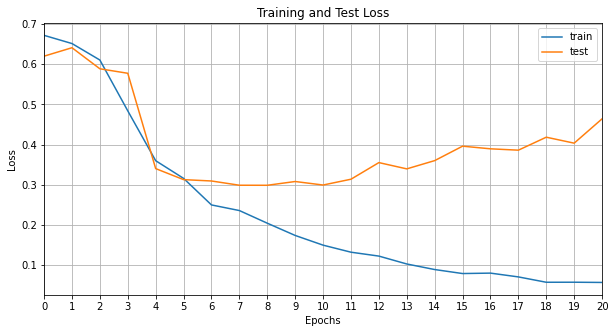

In [67]:
N_EPOCHS = 20

if TRAIN:
    best_test_loss = float('inf')
    best_test_acc = float('inf')

    train_losses = []
    test_losses = []
    
    for epoch in tqdm(range(N_EPOCHS+1)):
        start_time = time.time()
        
        # Train/eval
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        test_loss, test_acc = evaluate(model, test_iterator, criterion)
        
        #scheduler.step(test_loss)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        # Collect data
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if test_loss < best_test_loss:
            epochs_no_improve = 0
            best_test_loss = test_loss
            best_test_acc = test_acc
            torch.save(model.state_dict(), MODEL_PATH)
            
        # Plotting
        plot_training(train_losses, test_losses, N_EPOCHS)
            
        # Print data
        current_lr = get_lr(optimizer)
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | lr: {current_lr}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\tTest Loss: {test_loss:.3f}  | Test Acc: {test_acc*100:.2f}%')

    print(f'Best Test Loss: {best_test_loss:.3f} | Best Test Acc: {best_test_acc*100:.2f}%')

# 3. An estimated measure of what approximate accuracy we expect in the test set. <a class="anchor" id="chapter3"></a>

In [68]:
if LOAD:
    # Best model
    model.load_state_dict(torch.load(MODEL_PATH))

validation_loss, validation_acc = evaluate(model, validation_iterator, criterion)
print(f'Test Acc: {validation_acc*100:.2f}%')

Test Acc: 89.29%


## Prediction

In [69]:
nlp = spacy.load('en_core_web_lg')

def predict_sentiment(model, sentence):
    """
    Infer sentiment
    Parameters
    ----------
    model
    sentence

    Returns
    -------
    int:
        0 is good, 1 is bad
    """
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return 0 if prediction.item() > 0.5 else 1

## One example

In [70]:
%%time
predict_sentiment(model, 'The movie was very good')

CPU times: user 4.37 ms, sys: 949 µs, total: 5.32 ms
Wall time: 4.38 ms


1

In [74]:
predict_sentiment(model, 'the movie was very bad')

0

# 4. Create predictions for the test dataset. <a class="anchor" id="chapter4"></a>

In [71]:
target['sentiment'] = target.text.apply(lambda x: predict_sentiment(model, x))

In [72]:
target.to_csv('test.csv')